## Overview

This demo is a simple example of how to use CVIs incrementally (ICVI).
Here, we load a simple dataset and run a basic clustering algorithm to prescribe a set of clusters to the features.
We will take advantage of the fact that we can compute a criterion value at every step by running the ICVI alongside an online clustering algorithm.
This simple example demonstrates the usage of a single ICVI, but it may be substituted for any other ICVI in the `ClusterValidityIndices.jl` package.

## Online Clustering

### Data Setup

First, we must load all of our dependencies.
We will load the `ClusterValidityIndices.jl` along with some data utilities and the Julia `Clustering.jl` package to cluster that data.

In [1]:
using ClusterValidityIndices    # CVI/ICVI
using AdaptiveResonance         # DDVFA
using MLDatasets                # Iris dataset
using DataFrames                # DataFrames, necessary for MLDatasets.Iris()
using MLDataUtils               # Shuffling and splitting
using Printf                    # Formatted number printing
using Plots                     # Plots frontend
gr()                            # Use the default GR backend explicitly
theme(:dracula)                 # Change the theme for fun

We will download the Iris dataset for its small size and benchmark use for clustering algorithms.

In [2]:
iris = Iris(as_df=false)
features, labels = iris.features, iris.targets

([5.1 4.9 … 6.2 5.9; 3.5 3.0 … 3.4 3.0; 1.4 1.4 … 5.4 5.1; 0.2 0.2 … 2.3 1.8], InlineStrings.String15[InlineStrings.String15("Iris-setosa") InlineStrings.String15("Iris-setosa") … InlineStrings.String15("Iris-virginica") InlineStrings.String15("Iris-virginica")])

Because the MLDatasets package gives us Iris labels as strings, we will use the `MLDataUtils.convertlabel` method with the `MLLabelUtils.LabelEnc.Indices` type to get a list of integers representing each class:}

In [3]:
labels = convertlabel(LabelEnc.Indices{Int}, vec(labels))
unique(labels)

3-element Vector{Int64}:
 1
 2
 3

### ART Online Clustering

Adaptive Resonance Theory (ART) is a neurocognitive theory that is the basis of a class of online clustering algorithms.
Because these clustering algorithms run online, we can both cluster and compute a new criterion value at every step.
For more on these ART algorithms, see [`AdaptiveResonance.jl`](https://github.com/AP6YC/AdaptiveResonance.jl).

In [4]:
# Create a Distributed Dual-Vigilance Fuzzy ART (DDVFA) module with default options
art = DDVFA()
typeof(art)

AdaptiveResonance.DDVFA

Because we are streaming clustering, we must setup the internal data setup of the DDVFA module.
This is akin to doing some data preprocessing and communicating the dimension of the data, bounds, etc. to the module beforehand.

In [5]:
# Setup the data configuration for the module
data_setup!(art, features)
# Verify that the data is setup
art.config.setup

true

We can now cluster and get the criterion values online.
We will do this by creating an ICVI object, setting up containers for the iterations, and then iterating.

In [6]:
# Create an ICVI object
icvi = CH()

# Setup the online/streaming clustering
n_samples = length(labels)          # Number of samples
c_labels = zeros(Int, n_samples)    # Clustering labels
criterion_values = zeros(n_samples) # ICVI outputs

# Iterate over all samples
for ix = 1:n_samples
    # Extract one sample
    sample = features[:, ix]
    # Cluster the sample online
    c_labels[ix] = train!(art, sample)
    # Get the new criterion value (ICVI output)
    criterion_values[ix] = get_cvi!(icvi, sample, c_labels[ix])
end

# See the list of criterion values
criterion_values

150-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
 12.353295690914523
 12.1509583142854
 12.658861811198907
 13.139126596142964
 13.517957276687305
 13.284575851700808
 13.011911765129938
 13.35323771098832
 13.1625264757805

Because we ran it iteratively, we can also see how the criterion value evolved over time in a plot!

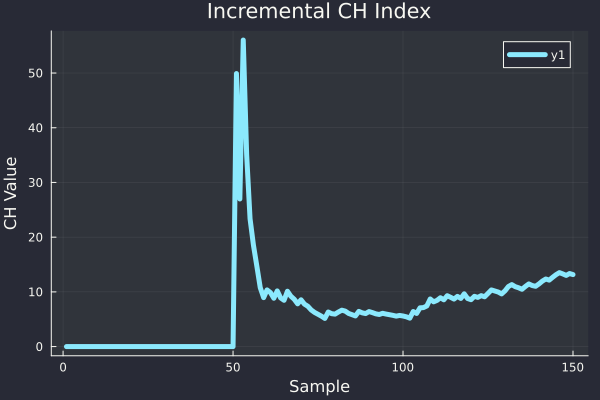

In [7]:
# Create the plotting object
p = plot(
    1:n_samples,
    criterion_values,
    linewidth = 5,
    title = "Incremental $(typeof(icvi)) Index",
    xlabel = "Sample",
    ylabel = "$(typeof(icvi)) Value",
)

Because of the visualization afforded by computing the criterion value incrementally, this plot can tell us several things.
First, we see that the CVI has a value of zero until the second cluster is encountered, which makes sense because there cannot be measurements of inter-/intra-cluster separation until there is more than one cluster.
Second, we see that the criterion value evolves at each time step as the clustering process occurs.

In [8]:
png("assets/icvi-example") #hide

"assets/icvi-example.png"

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*